In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
from src.utilities import processing as proc

from fastai.vision import *
import fastai.callbacks  
from fastai.utils.collect_env import *
show_install(True)



```text
=== Software === 
python       : 3.7.6
fastai       : 1.0.60
fastprogress : 0.2.2
torch        : 1.3.1
torch cuda   : None / is **Not available** 

=== Hardware === 
No GPUs available 

=== Environment === 
platform     : Darwin-17.7.0-x86_64-i386-64bit
conda env    : solaris
python       : /Users/brentsair/anaconda3/envs/solaris/bin/python
sys.path     : /Users/brentsair/Documents/Flatiron_School.nosync/SegmentingBuildings/notebooks/exploratory
/usr/local/Cellar/apache-spark/2.4.4/libexec/python
/python
/Users/brentsair/Documents/Flatiron_School.nosync/SegmentingBuildings/notebooks/exploratory
/Users/brentsair/anaconda3/envs/solaris/lib/python37.zip
/Users/brentsair/anaconda3/envs/solaris/lib/python3.7
/Users/brentsair/anaconda3/envs/solaris/lib/python3.7/lib-dynload

/Users/brentsair/anaconda3/envs/solaris/lib/python3.7/site-packages
/Users/brentsair/Documents/Flatiron_School.nosync/SegmentingBuildings
/Users/brentsair/anaconda3/envs/solaris/lib/python3.7/site-packages/IPyt

In [203]:
region = 'acc'
zone = '665946'
filepath_df = proc.make_filepath_df(region=region, zone=zone)

In [80]:
filepath_df.iloc[0][0]

'../../data/processed/images-256-acc-665946/acc665946train_19_261805_253917.png'

In [74]:
test = filepath_df.iloc[10][0]

In [75]:
test_mask = filepath_df.iloc[10][1]

In [35]:
#get the file path names for all of the COG tiles and label masks
region = 'acc'
zone = '665946'
fnames = get_image_files(f'../../data/processed/images-256-{region}-{zone}/')
lbl_names = get_image_files(f'../../data/processed/masks-256-{region}-{zone}/')

In [45]:
lbl_names[121]

PosixPath('../../data/processed/masks-256-acc-665946/acc665946train_19_261808_253934_mask.png')

In [53]:
fnames[121]

PosixPath('../../data/processed/images-256-acc-665946/acc665946train_19_261804_253931.png')

In [42]:
get_y_fn = lambda x: /f'{x.stem}_mask.png'

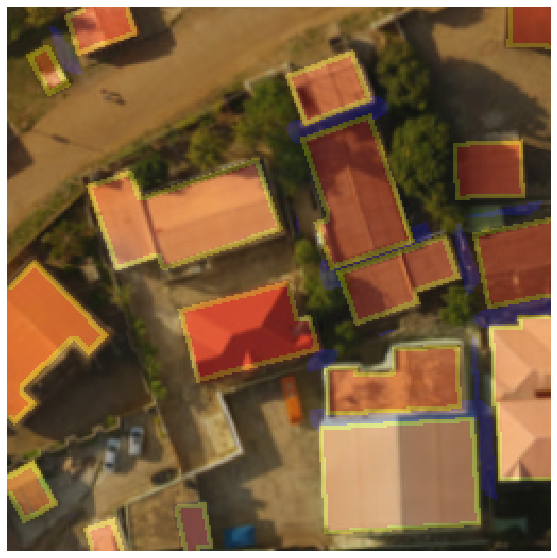

In [85]:
# test that masks are opening correctly with open_mask() settings
img_f = 120
img = open_image(filepath_df.iloc[img_f][0])
mask = open_mask(filepath_df.iloc[img_f][1], convert_mode='RGB', div=False)

fig, ax = plt.subplots(1,1, figsize=(10,10))
img.show(ax=ax)
mask.show(ax=ax, alpha=0.2)

(array([165849.,      0.,  30759.]),
 array([  0.,  85., 170., 255.]),
 <a list of 3 Patch objects>)

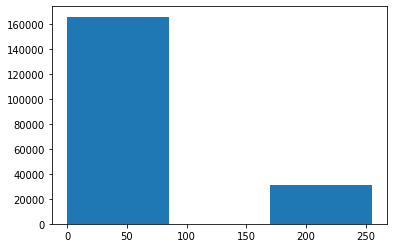

In [86]:
plt.hist(mask.data.view(-1), bins=3)

In [117]:
# define the valdation set by file name prefix
holdout_grids = ['acc665946validation_']
valid_idx = [i for i,o in enumerate(filepath_df.img_path) if any(c in str(o) for c in holdout_grids)]
print(len(valid_idx))

88


In [207]:
filepath_df['valid']=False
filepath_df.loc[valid_idx, 'valid'] = True

In [119]:
# subclassing SegmentationLabelList to set open_mask(fn, div=True, convert_mode='RGB') for 3 channel target masks

class SegLabelListCustom(SegmentationLabelList):
    def open(self, fn): return open_mask(fn, div=True, convert_mode='RGB')
    
class SegItemListCustom(SegmentationItemList):
    _label_cls = SegLabelListCustom

In [224]:
# define image transforms for data augmentation and create databunch. More about image tfms and data aug at https://docs.fast.ai/vision.transform.html 
tfms = get_transforms(flip_vert=True, max_warp=0.1, max_rotate=20, max_zoom=2, max_lighting=0.3)

# the classes corresponding to each channel
codes = np.array(['Footprint','Boundary','Contact'])

src = (SegmentationItemList.from_df(path='', df=filepath_df, cols='img_path')
       .split_from_df(col='valid')
       .label_from_df(cols='mask_path', classes=codes))


size = 256
bs = 16
data = (src.transform(tfms, size=size, tfm_y=True)
        .databunch(bs=bs))
        .normalize(imagenet_stats))

In [ ]:
data.normalize()